# have tried MOFA with
## unfiltered data with 10 factors - integration done with batch covariate Dataset and Donor
## unfiltered data with 20 factors - integration done with batch covariate Donor
## filtered data (removed amb cells and outliers) with 20 factors and ~3000 HVG(7000HVG each and intersection of those) - integration done with batch covariate Donor
## filtered data (removed amb cells and outliers) with 15 factors and 6082 HVG(120000 HVG and Intersection) - integration done with batch covariate Donor


In [2]:
# the goal of this NB is to look at the 15 factors and make them more specific to biological processes or cell types by removing overlapping genes

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown
import pandas as pd
from collections import defaultdict,Counter
import gc
import matplotlib.pyplot as plt
import pickle
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
 captum (see https://github.com/pytorch/captum).


In [6]:
m = mfx.mofa_model("../MOFA/MOFA_15_Factors_6082HVG/MOFA_results_even_more_hvg_more_factors_filtered_job.hdf5")

In [2]:
adata = sc.read_h5ad('../MOFA/adata_combined_even_more_hvg.h5ad')

In [3]:
weights = pd.read_csv('../MOFA/MOFA_15_Factors_6082HVG/weights.csv', index_col='Unnamed: 0')
genes = pd.read_csv('../MOFA/MOFA_15_Factors_6082HVG/genes.csv', index_col='Unnamed: 0')
factors = pd.read_csv('../MOFA/MOFA_15_Factors_6082HVG/latent_factors.csv', index_col='Unnamed: 0')

In [5]:
from collections import Counter

In [6]:
len((genes[:400].values.flatten()))

6000

In [7]:
count_df = pd.DataFrame.from_dict(Counter(genes[:400].values.flatten()), orient='index').sort_values(by=0, ascending=False)

In [8]:
count_df.head() #[count_df[0] == 15]

,0
SYNE2,10
TXNIP,9
NEAT1,9
TSC22D1,9
ZFP36L2,9


In [9]:
genes.shape

(6082, 15)

In [10]:
def remove_overlapping_genes(column):
    global assigned_genes
    # Create a new column with the same length, fill it with NaN initially
    unique_genes = [np.nan] * len(column)
    # Iterate over the column, keep only genes that are not assigned
    for i, gene in enumerate(column):
        if gene not in assigned_genes:
            unique_genes[i] = gene
            assigned_genes.add(gene)
    return unique_genes


In [48]:
top_500_per_factor = genes[:500]

In [49]:
len(set(top_500_per_factor.values.flatten()))

2478

In [50]:
assigned_genes = set()
for col in top_500_per_factor.columns:
    top_500_per_factor[col] = remove_overlapping_genes(top_500_per_factor[col])

In [51]:
top_500_per_factor = pd.DataFrame({col: top_500_per_factor[col].dropna().reset_index(drop=True) for col in top_500_per_factor.columns}).reindex(range(len(top_500_per_factor)))

In [52]:
top_500_per_factor.head(30)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,KRT19,CALD1,HLA-DRA,ZFP36L2,PLVAP,MUC6,XBP1,CADPS2,CTRL,FOLR2,ANKRD44,KCNE3,TBX2,ABCA8,SCG5
1,S100A6,COL1A2,CD74,BTG1,VWF,PRSS1,CYCS,FRY,GALNT10,HLA-DOA,BCL2,PLAC8,C1QTNF1,OAF,NISCH
2,KRT8,COL3A1,HLA-DRB1,TSC22D3,EGFL7,CELA3A,DDIT3,CRY1,SERINC5,FUCA1,STAT4,NFKBID,ACTG2,GPC3,ATP2A3
3,ELF3,FN1,SAT1,JUND,FLT1,CPB1,SLC3A2,STXBP5,PDIA2,CD79A,NCK2,PGC,RCAN2,GPSM3,PDZD2
4,ANXA2,COL6A3,TYROBP,CXCR4,ADGRL4,CPA1,SYAP1,STK38L,PLA2R1,C2,RCSD1,FAM3D,PLN,MMP23B,HIVEP3
5,IFI27,SPARCL1,FTL,TNFAIP3,AQP1,SLC3A1,ODC1,PDE4D,WIPF1,PIK3IP1,PRKCB,F5,ITGA7,CASP1,SYT7
6,KRT18,TIMP3,FCER1G,DNAJA1,PTPRB,DCDC2,CACYBP,NAV2,REG1B,CD40,MDFIC,MUC3A,STEAP4,CARD16,DZIP3
7,ANXA4,COL5A2,HLA-DPA1,JUN,SLCO2A1,PNLIP,NUDT4,SIK2,MAP3K5,SEC11C,INPP4A,PHGR1,CDH6,CHRDL1,PPM1L
8,AGR2,COL6A2,GLUL,IL7R,PODXL,REG1A,ANKRD37,GSE1,TPST2,SLAMF8,SEMA4D,BCL6,EFHD1,GPR171,MOB1B
9,TM4SF1,VIM,CTSS,CCL5,ELK3,SOX6,BAG3,PELI2,ERP27,MS4A1,CNTRL,VSIG1,RNF152,HSD11B1,FBXW7


In [16]:
dict_gp = top_400_per_factor.to_dict(orient='list')

In [17]:
import math
def is_not_nan(value):
    return not (isinstance(value, float) and math.isnan(value))
cleaned_dict_gp = {key: [gene for gene in genes if is_not_nan(gene)] for key, genes in dict_gp.items()}

In [62]:
for k,v in cleaned_dict_gp.items():
    # print(k)
    name = k.replace(' ','_') + '_score'
    print(f'Computing scorea for {k}')
    sc.tl.score_genes(adata, v, score_name=name, layer='log_norm', ctrl_as_ref=False)

Computing scorea for Factor1
Computing scorea for Factor2
Computing scorea for Factor3
Computing scorea for Factor4
Computing scorea for Factor5
Computing scorea for Factor6
Computing scorea for Factor7
Computing scorea for Factor8
Computing scorea for Factor9
Computing scorea for Factor10
Computing scorea for Factor11
Computing scorea for Factor12
Computing scorea for Factor13
Computing scorea for Factor14
Computing scorea for Factor15


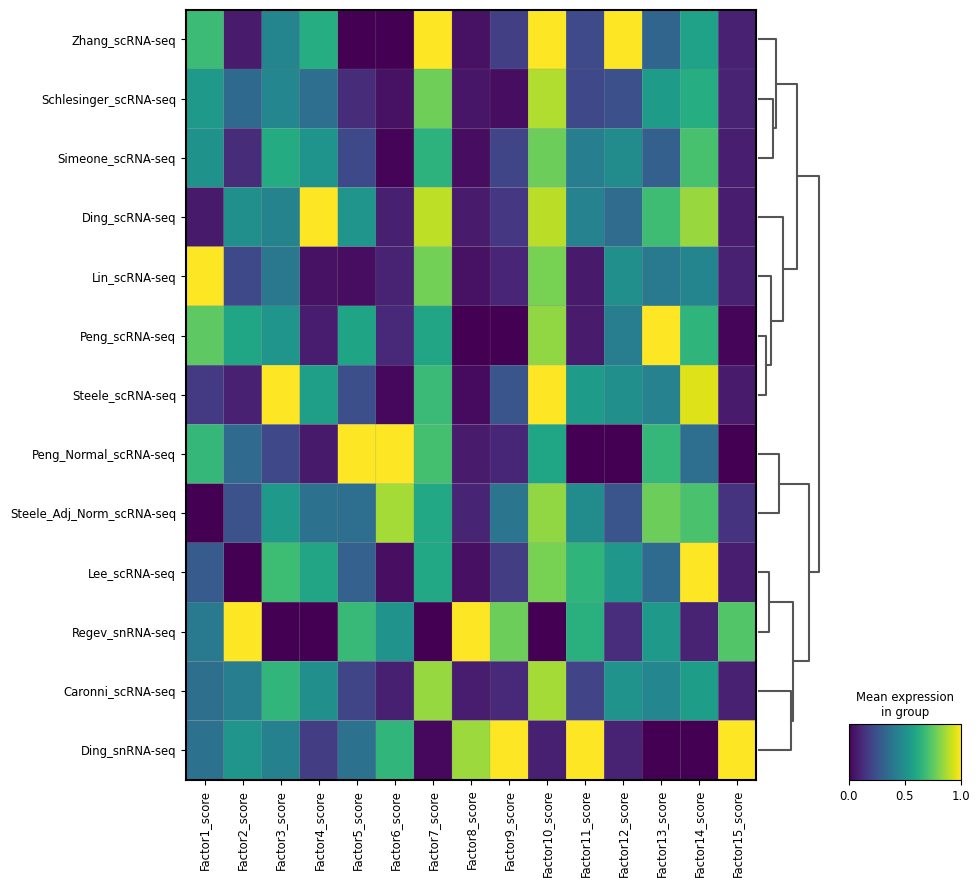

In [64]:
def make_score_cols(name=None):
    temp_list = []
    for i in adata.obs.columns:
        if 'Factor' in i:
            temp_list.append(i)
    if name:
        temp_list.append(name)
    return temp_list

score_cols = make_score_cols()

sc.pp.pca(adata)
sc.tl.dendrogram(adata, groupby='batch_covariate')
sc.pl.matrixplot(adata, score_cols, groupby='batch_covariate',  dendrogram=True, standard_scale='var', figsize=(10, 10), swap_axes=False)   

In [75]:
adata.obs.Level_1 = adata.obs.Level_1.replace('NK Cell', 'Natural Killer')
adata.obs.Level_1 = adata.obs.Level_1.replace('Ductal Cell/Malignant', 'Malignant')
adata.obs.Level_1 = adata.obs.Level_1.replace('Intra-pancreatic Neurons', 'Neuronal Cell')

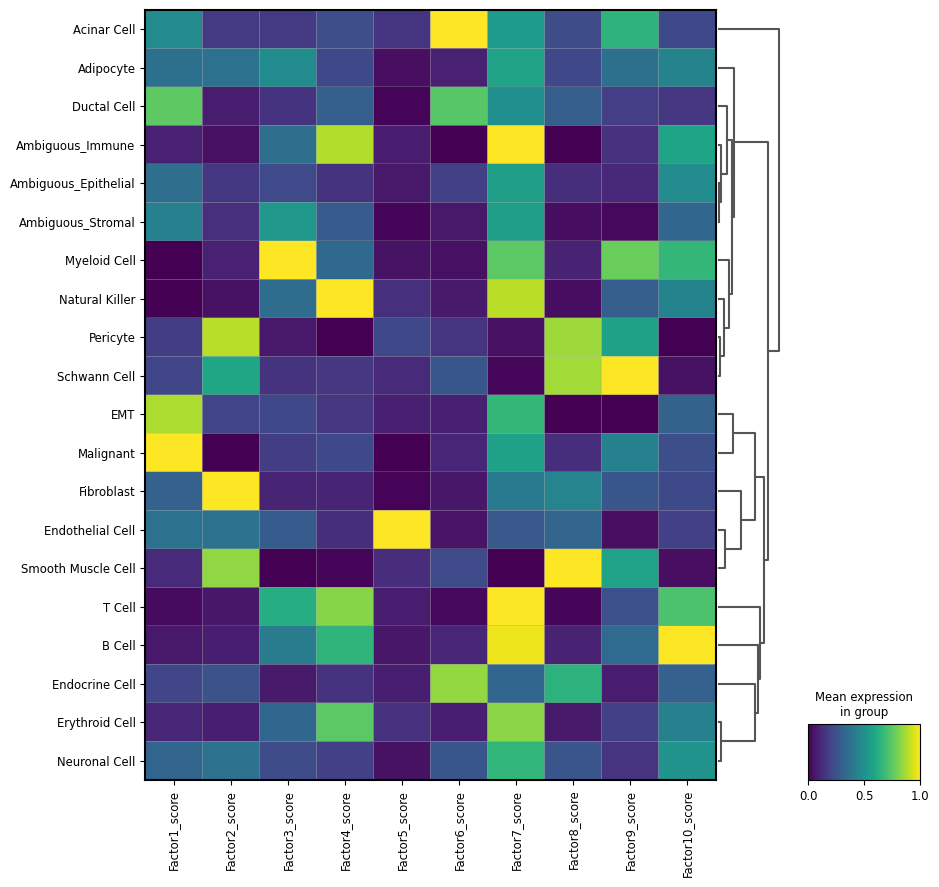

In [67]:
sc.tl.dendrogram(adata, groupby='Level_1')
sc.pl.matrixplot(adata, score_cols[:10], groupby='Level_1',  dendrogram=True, figsize=(10, 10), swap_axes=False, standard_scale='var')   

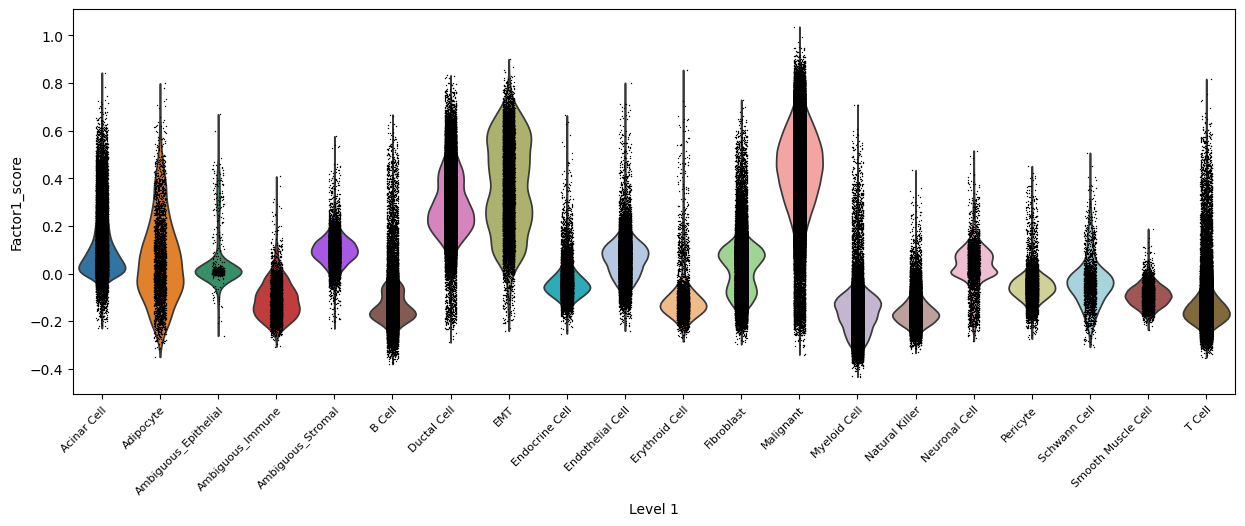

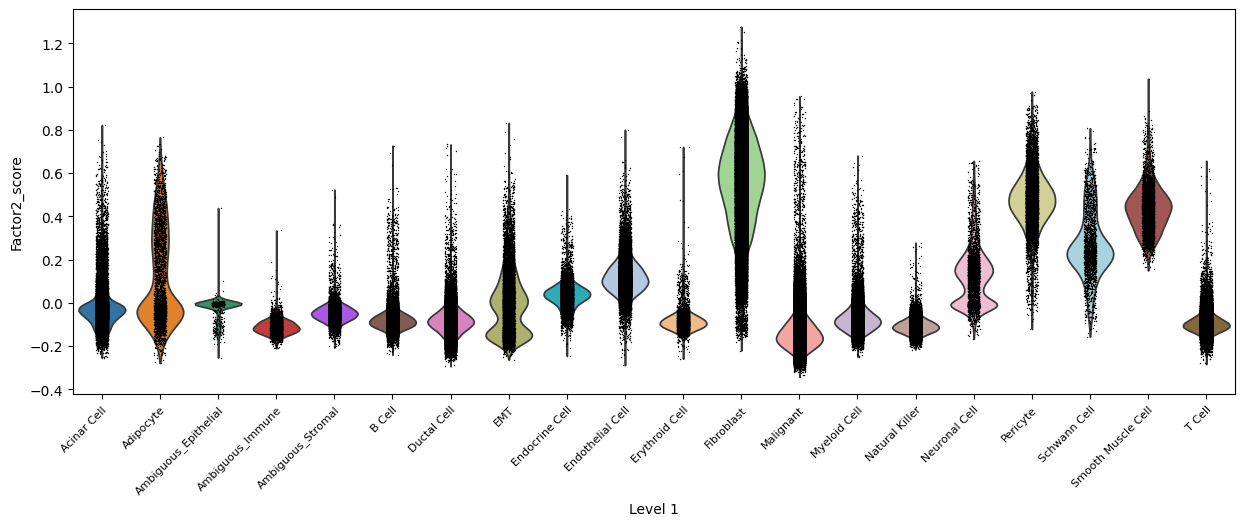

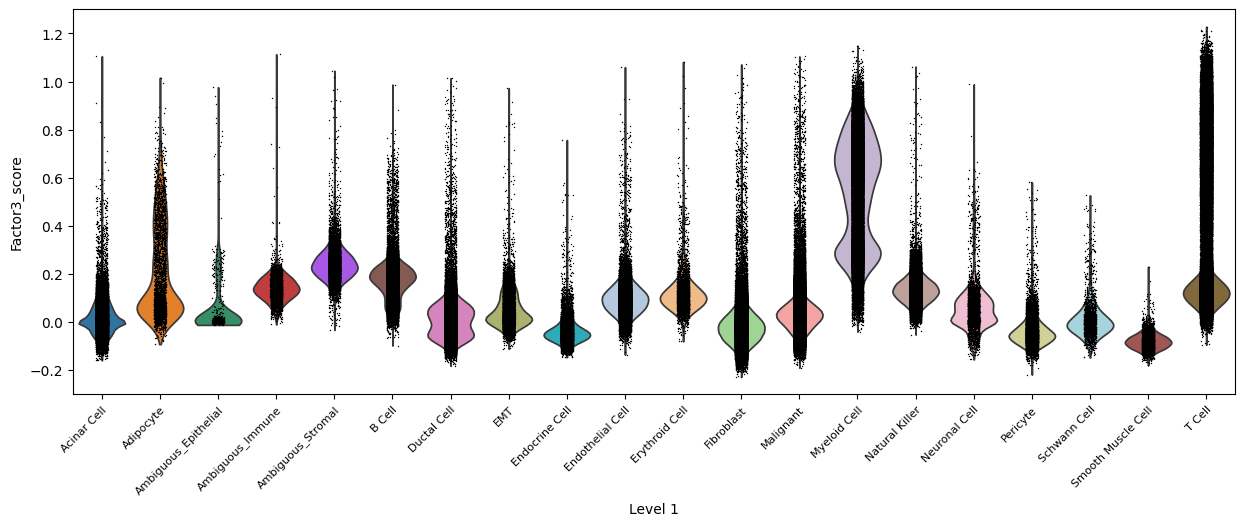

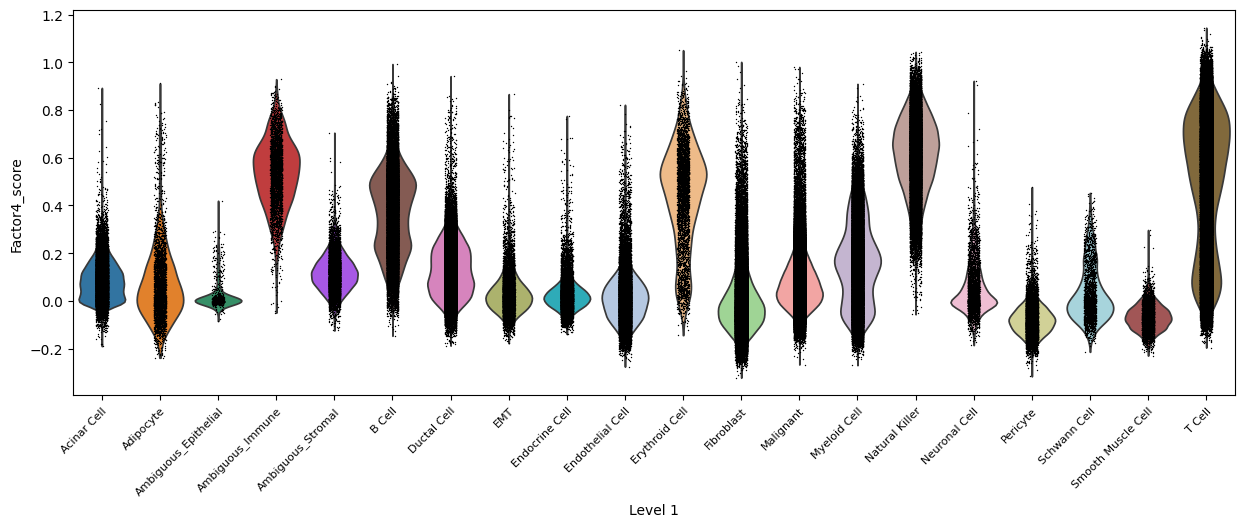

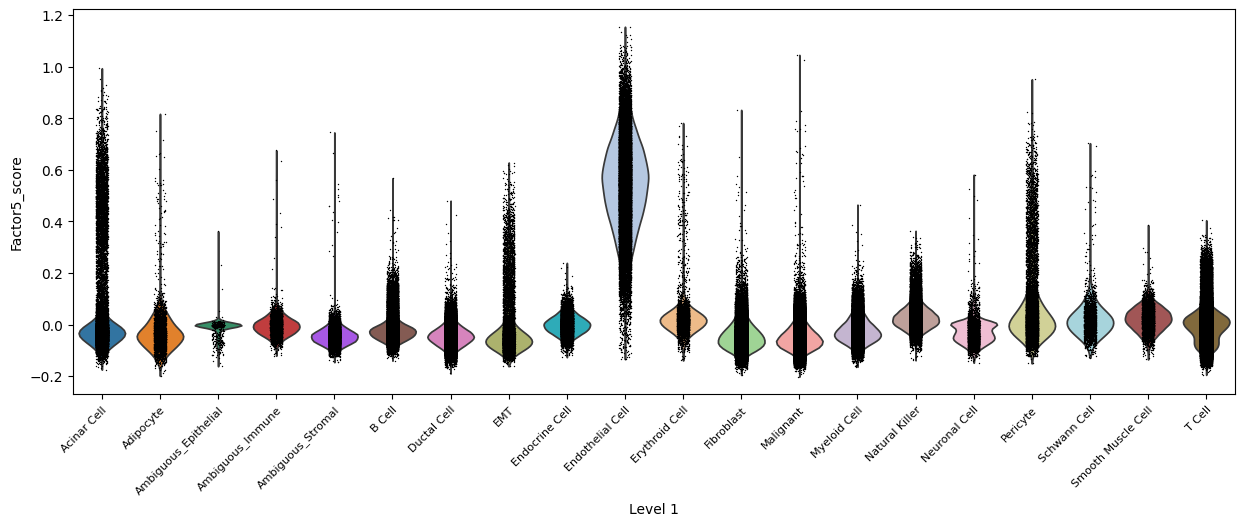

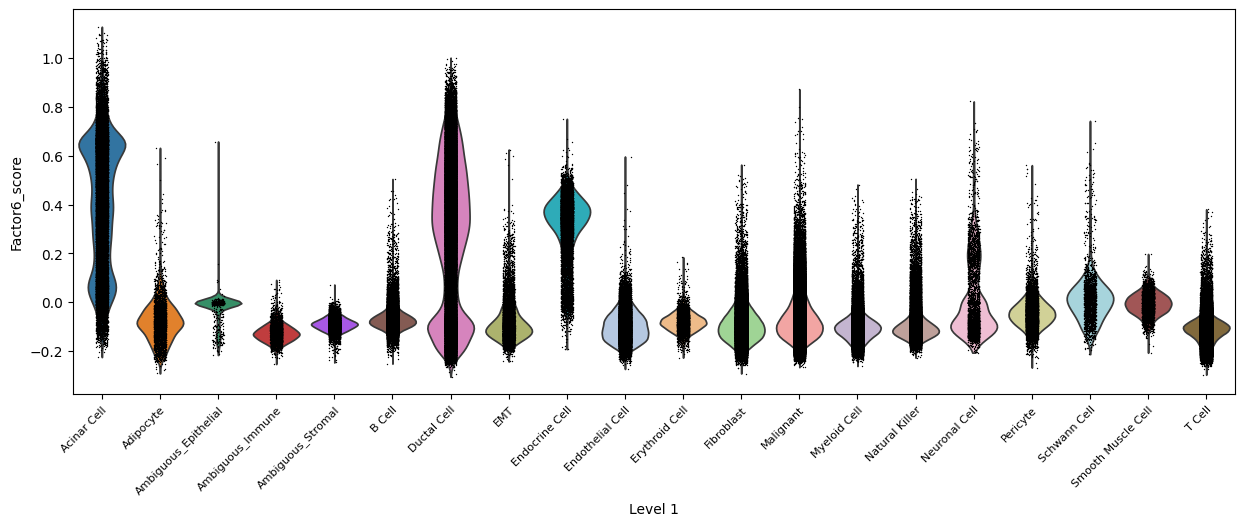

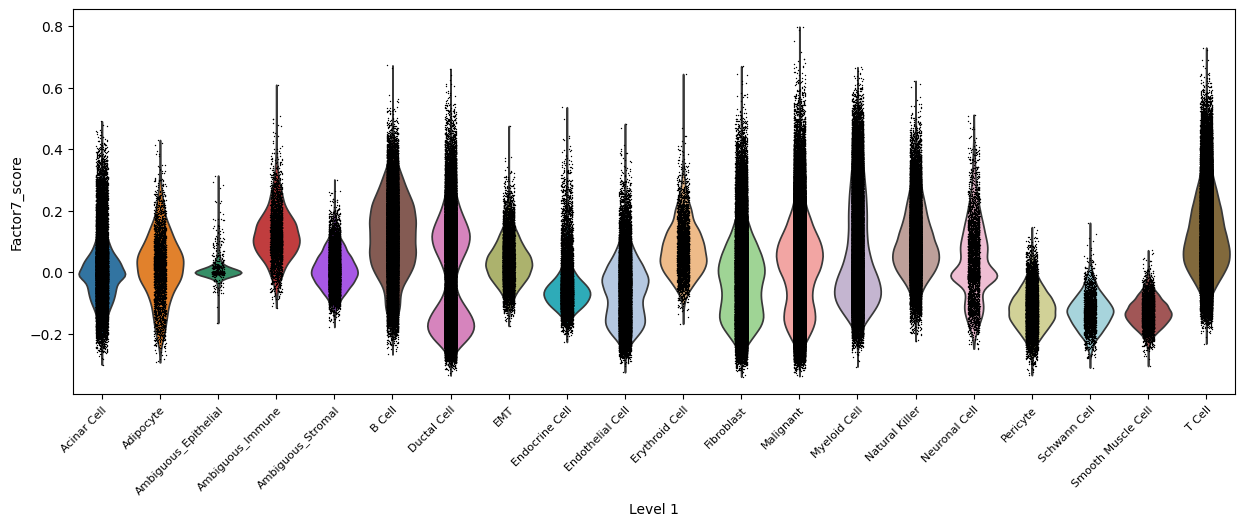

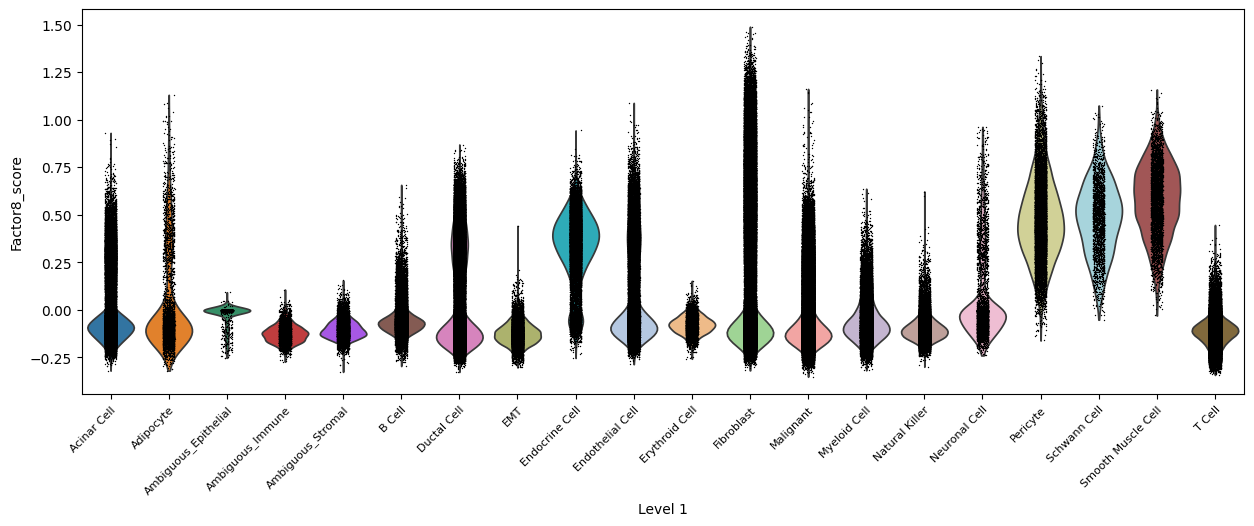

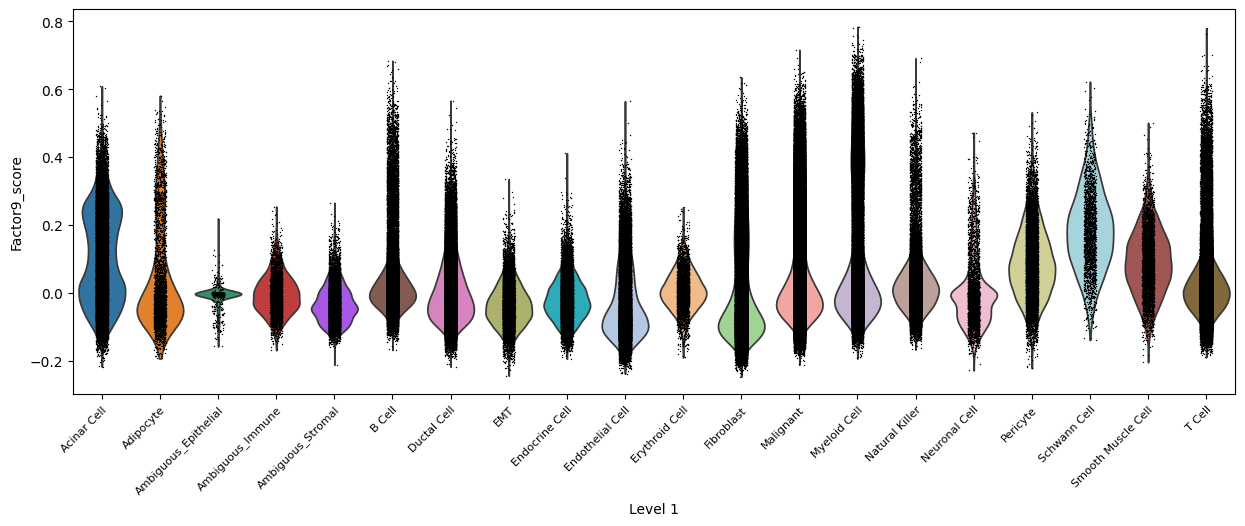

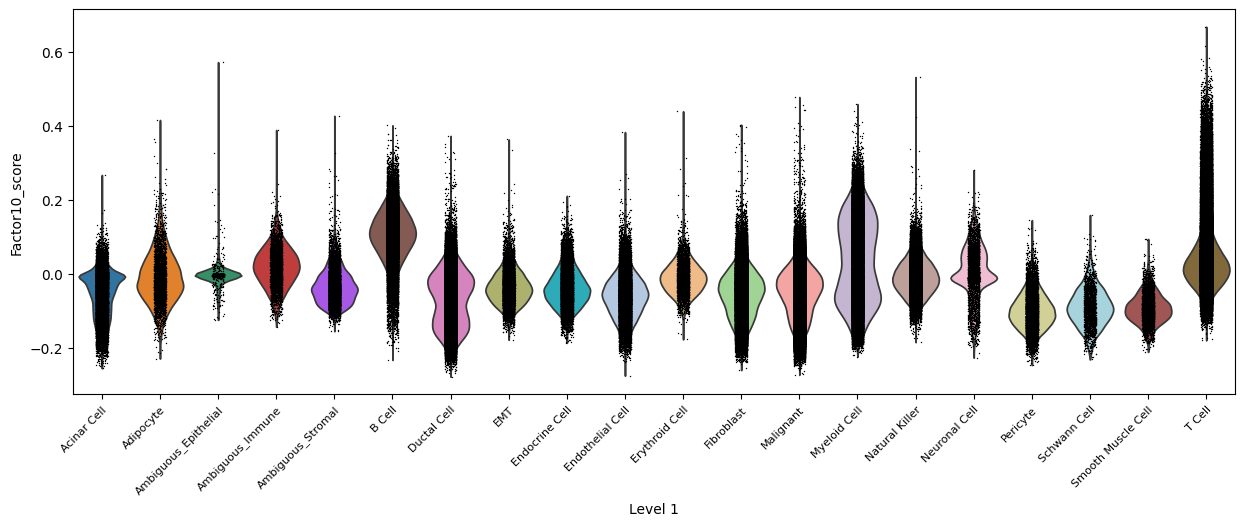

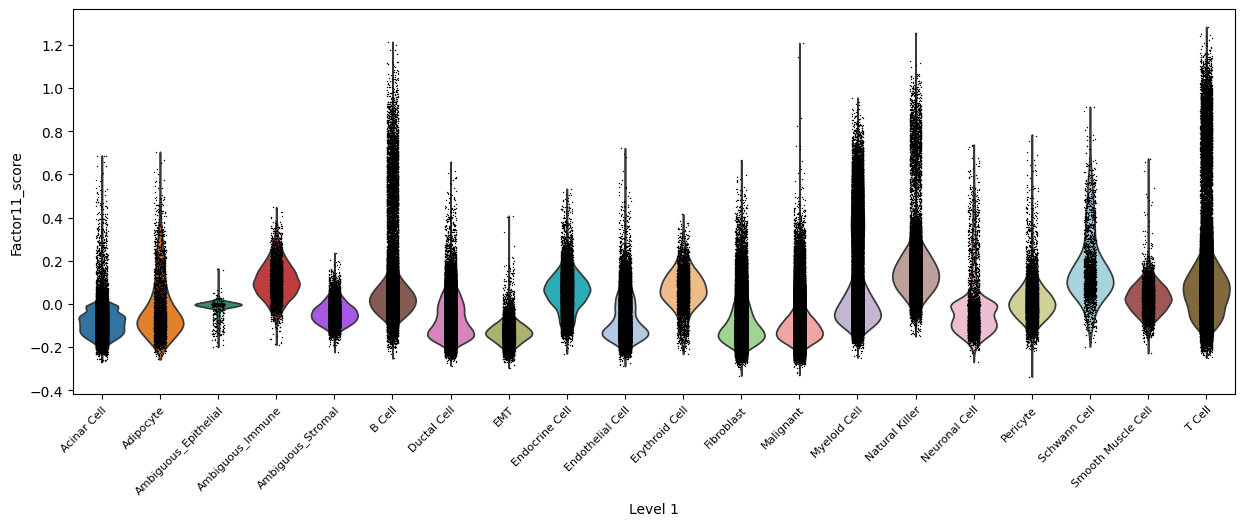

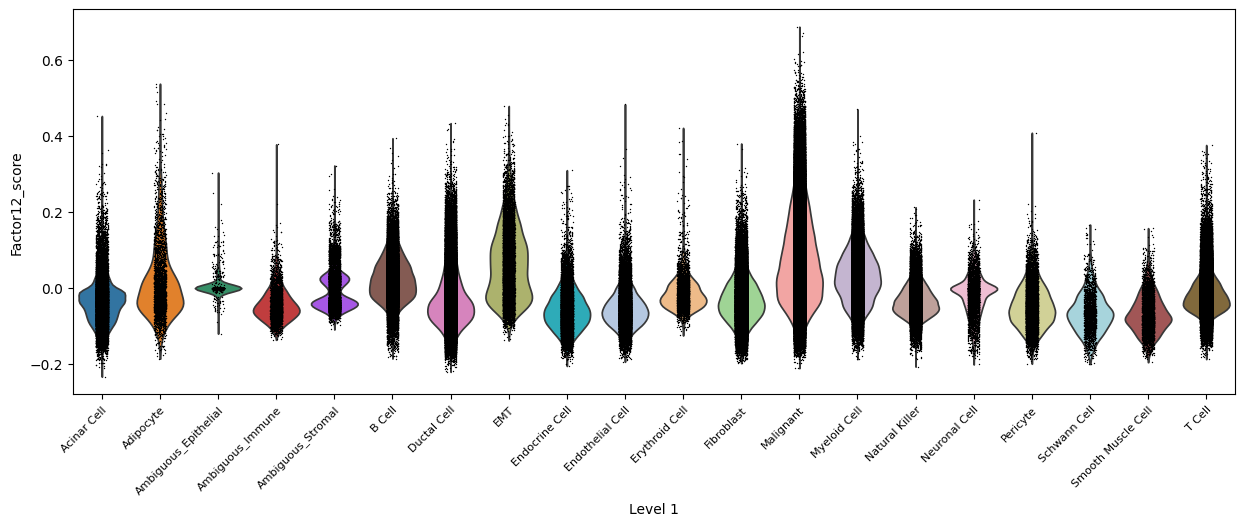

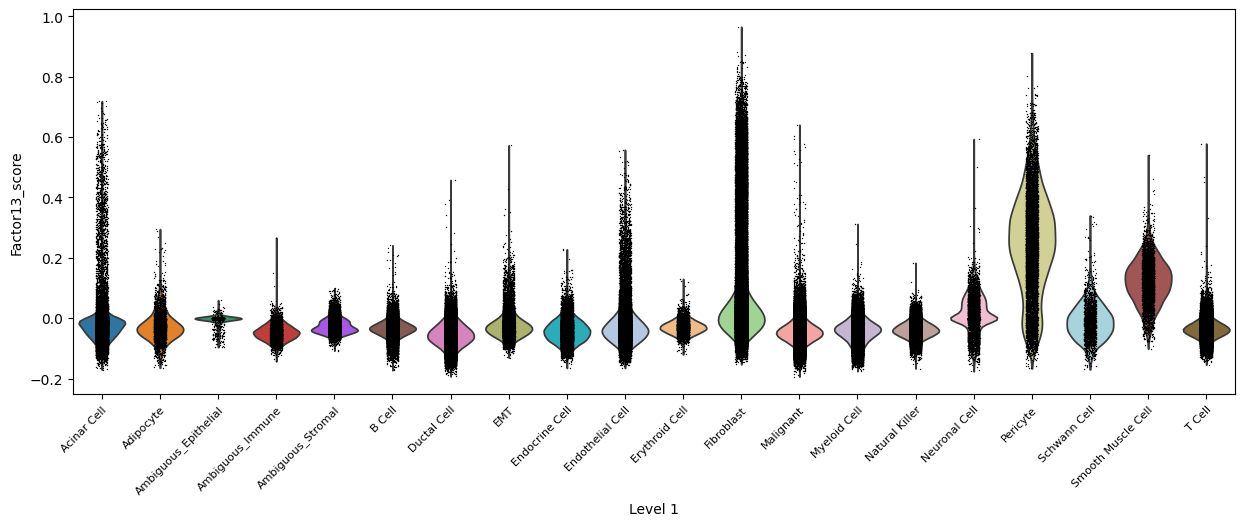

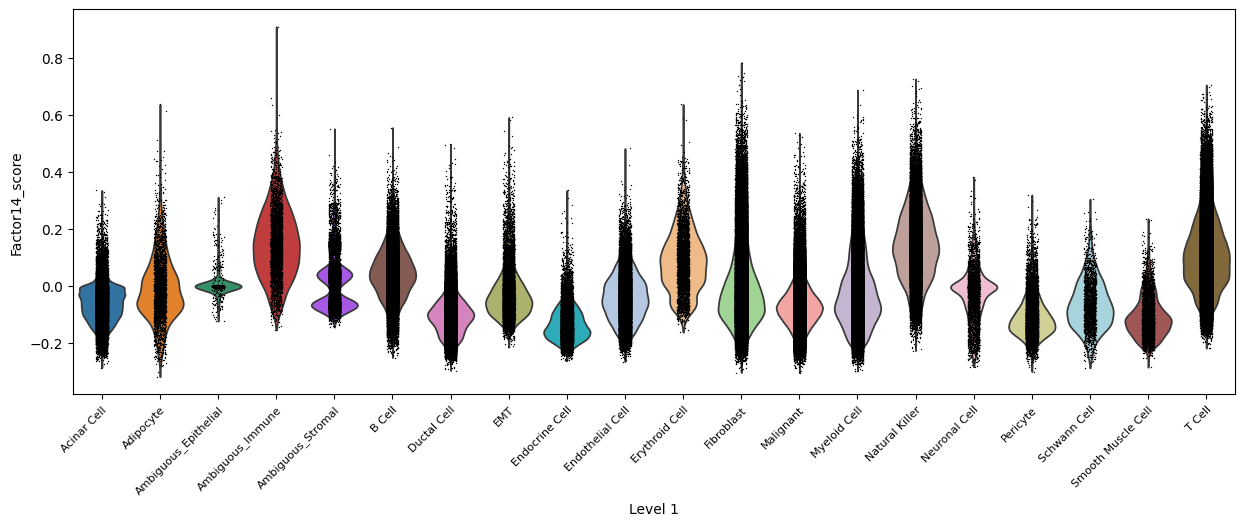

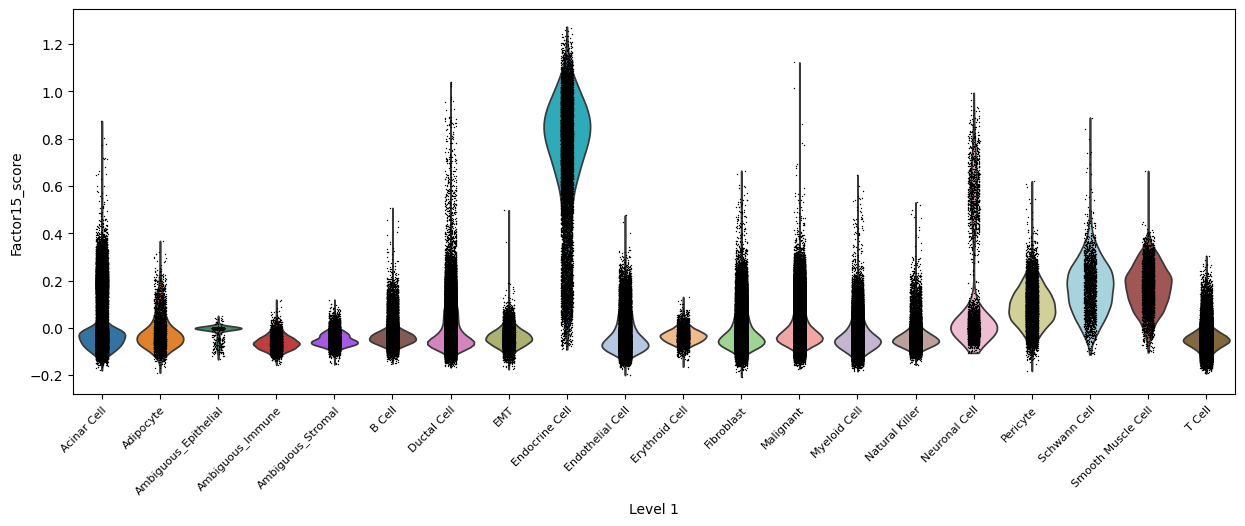

In [76]:
plt.rcParams['figure.figsize'] = (15,5)
for fac in score_cols:
    fig, ax = plt.subplots()  
    sc.pl.violin(adata, keys=fac, groupby='Level_1', ax=ax, show=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=45, ha='right', rotation_mode='anchor') 
    plt.show()  

In [53]:
top_500_per_factor.head()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,KRT19,CALD1,HLA-DRA,ZFP36L2,PLVAP,MUC6,XBP1,CADPS2,CTRL,FOLR2,ANKRD44,KCNE3,TBX2,ABCA8,SCG5
1,S100A6,COL1A2,CD74,BTG1,VWF,PRSS1,CYCS,FRY,GALNT10,HLA-DOA,BCL2,PLAC8,C1QTNF1,OAF,NISCH
2,KRT8,COL3A1,HLA-DRB1,TSC22D3,EGFL7,CELA3A,DDIT3,CRY1,SERINC5,FUCA1,STAT4,NFKBID,ACTG2,GPC3,ATP2A3
3,ELF3,FN1,SAT1,JUND,FLT1,CPB1,SLC3A2,STXBP5,PDIA2,CD79A,NCK2,PGC,RCAN2,GPSM3,PDZD2
4,ANXA2,COL6A3,TYROBP,CXCR4,ADGRL4,CPA1,SYAP1,STK38L,PLA2R1,C2,RCSD1,FAM3D,PLN,MMP23B,HIVEP3


In [82]:
all_genes = [x for x in list(set(top_500_per_factor.values.flatten().astype(str))) if x!= 'nan']
binary_matrix = pd.DataFrame(0, index=all_genes, columns=top_500_per_factor.columns)
for column in top_500_per_factor.columns:
    genes_in_program = top_500_per_factor[column].dropna()
    binary_matrix.loc[genes_in_program, column] = 1

In [84]:
binary_matrix.to_csv('../MOFA/MOFA_15_Factors_6082HVG/binary_matrix_15_factors.csv')

In [54]:
# select first 10 factors
cols = ['Factor' + str(i+1) for i in list(range(10))]
subset = top_500_per_factor[cols]

In [55]:
all_genes = [x for x in list(set(subset.values.flatten().astype(str))) if x!= 'nan']
binary_matrix = pd.DataFrame(0, index=all_genes, columns=subset.columns)
for column in subset.columns:
    genes_in_program = subset[column].dropna()
    binary_matrix.loc[genes_in_program, column] = 1

In [70]:
binary_matrix.to_csv('../MOFA/MOFA_15_Factors_6082HVG/binary_matrix.csv')

In [ ]:
adata_gp = adata[:, all_genes]

adata_gp.varm['I'] = np.array(binary_matrix)
select_terms = adata_gp.varm['I'].sum(0)>12

adata_gp.uns['terms'] = binary_matrix.columns
adata_gp._inplace_subset_var(adata_gp.varm['I'].sum(1)>0)

adata_gp.uns['terms']

In [62]:
print('Checking X')
subset = sc.pp.subsample(adata_gp, fraction=0.1, copy=True)
raw_counts = subset.X.toarray()
print(f"Are raw counts integers? {np.all(raw_counts.astype(int) == raw_counts)}")
print(f"Range of raw counts: {np.min(raw_counts)} to {np.max(raw_counts)}")
print("-" * 50)

Checking X
Are raw counts integers? True
Range of raw counts: 0.0 to 159376.0
--------------------------------------------------


In [65]:
adata_gp.obs.ID = adata_gp.obs.ID.astype(str)
adata_gp.obs.batch_covariate = adata_gp.obs.batch_covariate.astype(str)
adata_gp.obs['ID_batch_covariate'] = adata_gp.obs.ID + '_' + adata_gp.obs.batch_covariate
adata_gp.obs.ID_batch_covariate = adata_gp.obs.ID_batch_covariate.astype('category')
adata_gp.obs.ID = adata_gp.obs.ID.astype('category')

In [67]:
adata_gp.obs['ID_batch_covariate'].unique()

['HT056P1_Ding_scRNA-seq', 'HT060P1_Ding_scRNA-seq', 'HT061P1_Ding_scRNA-seq', 'HT064P1_Ding_scRNA-seq', 'HT071P1_Ding_scRNA-seq', ..., 'HT270P1_Ding_snRNA-seq', 'HT284P1_Ding_snRNA-seq', 'HT288P1_Ding_snRNA-seq', 'HT306P1_Ding_snRNA-seq', 'HT412P1_Ding_snRNA-seq']
Length: 192
Categories (192, object): ['AdjNorm_TISSUE_1_Steele_Adj_Norm_scRNA-seq', 'AdjNorm_TISSUE_2_Steele_Adj_Norm_scRNA-seq', 'AdjNorm_TISSUE_3_Steele_Adj_Norm_scRNA-seq', 'GSM4293555_Schlesinger_scRNA-seq', ..., 'U6_Regev_snRNA-seq', 'U7_Regev_snRNA-seq', 'U8_Regev_snRNA-seq', 'U9_Regev_snRNA-seq']

In [ ]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata_gp,
    condition_key='ID_batch_covariate',
    hidden_layer_sizes=[300, 300, 300],
    recon_loss='nb'
)

adata_gp.X = adata_gp.X.astype('float32')

ALPHA = 0.7
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=200,
    alpha_epoch_anneal=50,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020
)

In [ ]:
adata_gp.obsm['X_cvae'] = intr_cvae.get_latent(mean=False, only_active=True)
adata_gp.uns['terms'] = adata_gp.uns['terms'].tolist()

In [ ]:
adata_gp.write('../Expimap/int_10_factors_selected_norepeatinggenes.h5ad')
intr_cvae.save('../Expimap/expimap_10_factors_selected_norepeatinggenes')

In [ ]:
sc.pp.neighbors(adata_gp, use_rep='X_cvae')
sc.tl.umap(adata_gp)

In [ ]:
adata_gp.write('../Expimap/int_10_factors_selected_norepeatinggenes.h5ad')